This code generates all the data required for this study, and produces the plots included in the paper [arXiv:1911.12299]

Needs the ThickBrick package to run. Compatible with version 0.1.0.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import math

plt.rcParams.update({'font.size': 18})
plt.rcParams['mathtext.fontset'] = 'stix'
np.random.seed(0)
logit = lambda p: np.log(p) - np.log1p(-p)

In [3]:
class const_cat:
    def __init__(self, th):
        self.th = th
    
    def categorize(self, x, p):
        return (p>=self.th) - 1

In [4]:
N = 10**6

bg_e = np.random.uniform(low=-10, high=10, size=(N,2))

sigma1, sigma2 = 2., 3.
sig_e = np.random.multivariate_normal(mean=[0.,0.], cov=[[sigma1**2.,0.],[0.,sigma2**2.]], size=N)
to_redo = (np.amax(np.absolute(sig_e), axis=1) > 10.)
while np.any(to_redo):
    sig_e[to_redo] = np.random.multivariate_normal(mean=[0.,0.], cov=[[sigma1**2.,0.],[0.,sigma2**2.]], size=np.sum(to_redo))
    to_redo = (np.amax(np.absolute(sig_e), axis=1) > 10.)

training_e = np.concatenate((bg_e[:N//2, :], sig_e[:N//2, :]))
training_y = np.concatenate((np.zeros(N//2), np.ones(N//2)))
shuffle_index = np.arange(len(training_e))
np.random.shuffle(shuffle_index)
training_e = training_e[shuffle_index, :]
training_y = training_y[shuffle_index]

testing_e = np.concatenate((bg_e[N//2:, :], sig_e[N//2:, :]))
testing_y = np.concatenate((np.zeros(N-N//2), np.ones(N-N//2)))
shuffle_index = np.arange(len(testing_e))
np.random.shuffle(shuffle_index)
testing_e = testing_e[shuffle_index, :]
testing_y = testing_y[shuffle_index]

In [5]:
def bg_pdf(e):
    return np.full(e.shape[:-1], .0025)

def sig_pdf(e):
    e_0, e_1 = e[...,0], e[...,1]
    
    # signal_norm_factor accounts for the truncation of the multivariate normal distribution.
    # It is pretty close to 1 (1.0476698269038498 for sigma1 = 2., sigma2 = 5.)
    signal_norm_factor = 4. / ((math.erf(10./(sigma1 * math.sqrt(2))) - math.erf(-10./(sigma1 * math.sqrt(2.)))) \
                               * (math.erf(10./(sigma2 * math.sqrt(2))) - math.erf(-10./(sigma2 * math.sqrt(2.)))))
    
    return signal_norm_factor * (0.5/(np.pi*sigma1*sigma2)) * np.exp( -0.5*e_0**2./sigma1**2. ) * np.exp( -0.5*e_1**2./sigma2**2. )

def prob_function(e, scale=1.):
    scaled_sig_pdf_vals = scale*sig_pdf(e)
    bg_pdf_vals = bg_pdf(e)
    return scaled_sig_pdf_vals/(bg_pdf_vals+scaled_sig_pdf_vals)

def reverse_prob_e_1(p, e_0):
    sig_pdf = .0025*p/(1-p)
    signal_norm_factor = 4. / ((math.erf(10./(sigma1 * math.sqrt(2))) - math.erf(-10./(sigma1 * math.sqrt(2.)))) \
                               * (math.erf(10./(sigma2 * math.sqrt(2))) - math.erf(-10./(sigma2 * math.sqrt(2.)))))
    
    return np.sqrt(np.log(sig_pdf/(signal_norm_factor * (0.5/(np.pi*sigma1*sigma2)) * np.exp( -0.5*e_0**2./sigma1**2. )))*(-2*sigma2**2.))

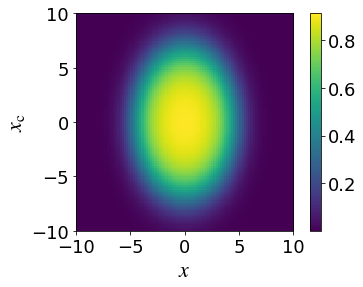

In [6]:
x1 = np.linspace(-10, 10, 100)
x2 = np.linspace(-10, 10, 100)
x1, x2 = np.meshgrid(x1, x2)
sig_pdf_val = sig_pdf(np.array([x1.T,x2.T]).T)
prob_val = prob_function(np.array([x1.T,x2.T]).T)

plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
plt.imshow(sig_pdf_val, extent=[-10, 10, -10, 10])
plt.colorbar()
ax.set_aspect('equal')
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$x_\mathrm{c}$', fontsize=22)
plt.savefig('sig_dist.pdf', bbox_inches='tight')

plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
plt.imshow(prob_val, extent=[-10, 10, -10, 10])
plt.colorbar()
ax.set_aspect('equal')
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$x_\mathrm{c}$', fontsize=22)
plt.savefig('p_plot.pdf', bbox_inches='tight')

In [7]:
training_p = prob_function(training_e)
training_logit_p = logit(training_p)

testing_p = prob_function(testing_e)
testing_logit_p = logit(testing_p)

training_x = training_e[:, 0]
testing_x = testing_e[:, 0]

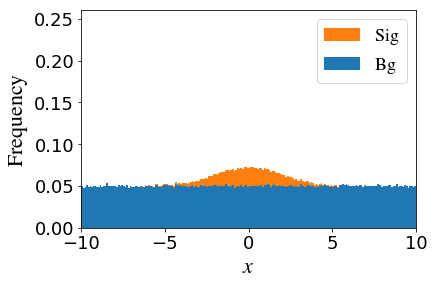

In [8]:
plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
bins=200
plt.hist2d(training_x[:N], training_logit_p[:N], bins=bins, range=((-10, 10),(-15,5)), \
                                       weights=np.full(N, bins**2./(N*20.*20.)), norm=LogNorm())
plt.colorbar()
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$\mathrm{logit}(p)$', fontsize=22)
ax.set_rasterized(True)
plt.savefig('x_logit.pdf', bbox_inches='tight')

Nb = training_x[training_y==0].size
Ns = training_x[training_y==1].size
bins = 200

plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
ax.hist([training_x[training_y==0], training_x[training_y==1]], stacked=True, bins=bins, \
                                    range=(-10, 10), weights=[np.full(Nb, bins/(20.*Nb)), np.full(Ns, bins/(20.*Ns))], \
                                    label=[r"$\mathrm{Bg}$", r"$\mathrm{Sig}$"], histtype='stepfilled')
ax.set_xlim(-10, 10)
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$\mathrm{Frequency}$', fontsize=22)
ax.legend()
ax.set_ylim(0, 0.260)
plt.savefig('before_selection.pdf', bbox_inches='tight')

plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
ax.hist([training_x[training_y==0], training_x[training_y==1]], stacked=True, bins=bins, \
                                    range=(-10, 10), weights=[np.full(Nb, bins/(20.*Nb)), np.full(Ns, (1/9.)*bins/(20.*Ns))], \
                                    label=[r"$\mathrm{Bg}$", r"$\mathrm{Sig}$"], histtype='stepfilled')
ax.set_xlim(-10, 10)
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$\mathrm{Frequency}$', fontsize=22)
ax.set_ylim(0, 0.260)
ax.legend()
plt.savefig('before_selection_10percent.pdf', bbox_inches='tight')

In [9]:
import thickbrick as taab
import thickbrick.KernelRegression as kerreg

In [10]:
evaluator = taab.Evaluator(statistical_distance="Pearson_chisq", \
                                       regression_method=kerreg.NW_kerreg_1d, default_regression_options={'bandwidth': .01})
evaluator.set_data(x = testing_x, p = testing_p)

In [11]:
autocategorizer = taab.Autocategorizer(category_count=1, allow_rejection=True, statistical_distance="Pearson_chisq", \
                                       regression_method=kerreg.NW_kerreg_1d, default_regression_options={'bandwidth': 100})

In [12]:
autocategorizer.set_data(x = training_x, p = training_p)

In [13]:
autocategorizer.initialize_categorizer(mode='random_assignment')

In [14]:
for i in range(20):
    print(f"Training step {i+1:2}: ", end='')
    print(autocategorizer.training_step())

Training step  1: {'category_reassignment_count': 499948}
Training step  2: {'category_reassignment_count': 110609}
Training step  3: {'category_reassignment_count': 53395}
Training step  4: {'category_reassignment_count': 23444}
Training step  5: {'category_reassignment_count': 9660}
Training step  6: {'category_reassignment_count': 3840}
Training step  7: {'category_reassignment_count': 1558}
Training step  8: {'category_reassignment_count': 606}
Training step  9: {'category_reassignment_count': 269}
Training step 10: {'category_reassignment_count': 97}
Training step 11: {'category_reassignment_count': 33}
Training step 12: {'category_reassignment_count': 18}
Training step 13: {'category_reassignment_count': 7}
Training step 14: {'category_reassignment_count': 0}
Training step 15: {'category_reassignment_count': 0}
Training step 16: {'category_reassignment_count': 0}
Training step 17: {'category_reassignment_count': 0}
Training step 18: {'category_reassignment_count': 0}
Training ste

In [15]:
cat = autocategorizer.get_current_categorizer()

In [16]:
print(evaluator.evaluate(cat, 1))
print(evaluator.evaluate(cat, 1, signal_scale=1./9))
cat.boundaries(0)

2.2541467360632974
0.05007866133322675


array([0.75130651])

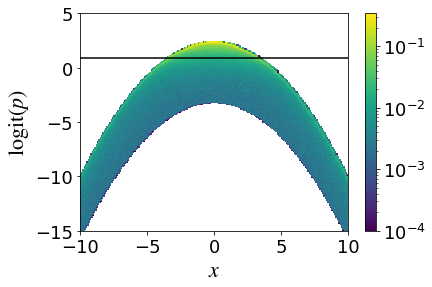

In [17]:
plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
bins=200
plt.hist2d(training_x[:N], training_logit_p[:N], bins=bins, range=((-10, 10),(-15,5)), \
                                       weights=np.full(N, bins**2./(N*20.*20.)), norm=LogNorm())
#plt.plot([-10,10], [logit(cat.boundaries(0)), logit(cat.boundaries(0))], color='black')
#plt.plot([-10,10], [logit(.778), logit(.778)], color='black')
plt.plot([-10,10], [logit(.715), logit(.715)], color='black')
plt.colorbar()
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$\mathrm{logit}(p)$', fontsize=22)
ax.set_rasterized(True)
plt.savefig('x_logit_flatcut.pdf', bbox_inches='tight')

In [18]:
cat = const_cat(.715)
testing_categories = cat.categorize(testing_x, testing_p)
selected_x = testing_x[testing_categories==0]
selected_p = testing_p[testing_categories==0]
selected_y = testing_y[testing_categories==0]

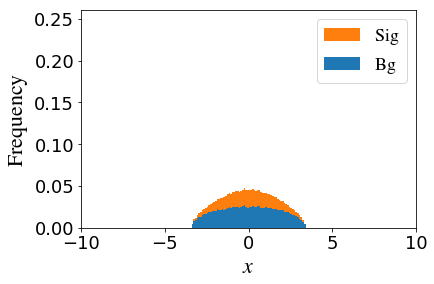

In [19]:
Nb_ = testing_x[testing_y==0].size
Ns_ = testing_x[testing_y==1].size

Nb = selected_x[selected_y==0].size
Ns = selected_x[selected_y==1].size
bins = 200

plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
ax.hist([selected_x[selected_y==0], selected_x[selected_y==1]], stacked=True, bins=bins, \
                                    range=(-10, 10), weights=[np.full(Nb, bins/(20.*Nb_)), np.full(Ns, bins/(20.*Ns_))], \
                                    label=[r"$\mathrm{Bg}$", r"$\mathrm{Sig}$"], histtype='stepfilled')
ax.set_xlim(-10, 10)
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$\mathrm{Frequency}$', fontsize=22)
ax.legend()
ax.set_ylim(0, 0.260)
plt.savefig('flat_selection.pdf', bbox_inches='tight')

plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
ax.hist([selected_x[selected_y==0], selected_x[selected_y==1]], stacked=True, bins=200, \
                                    range=(-10, 10), weights=[np.full(Nb, bins/(20.*Nb_)), np.full(Ns, (1/9.)*bins/(20.*Ns_))], \
                                    label=[r"$\mathrm{Bg}$", r"$\mathrm{Sig}$"], histtype='stepfilled')
ax.set_xlim(-10, 10)
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$\mathrm{Frequency}$', fontsize=22)
ax.set_ylim(0, 0.260)
ax.legend()
plt.savefig('flat_selection_10percent.pdf', bbox_inches='tight')

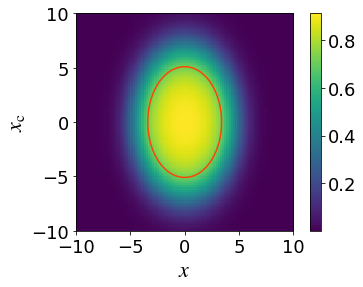

In [20]:
x1 = np.linspace(-10, 10, 100)
x2 = np.linspace(-10, 10, 100)
x1, x2 = np.meshgrid(x1, x2)
sig_pdf_val = sig_pdf(np.array([x1.T,x2.T]).T)
prob_val = prob_function(np.array([x1.T,x2.T]).T)

plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
plt.imshow(prob_val, extent=[-10, 10, -10, 10])
plt.colorbar()
#plt.contour(x1, x2, prob_val, [cat.boundaries(0)], colors=['orangered'])
plt.contour(x1, x2, prob_val, [.715], colors=['orangered'])
ax.set_aspect('equal')
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$x_\mathrm{c}$', fontsize=22)
plt.savefig('flatcut_p_plot.pdf', bbox_inches='tight')

In [21]:
autocategorizer = taab.Autocategorizer(category_count=1, allow_rejection=True, statistical_distance="Pearson_chisq", \
                                       regression_method=kerreg.NW_kerreg_1d, default_regression_options={'bandwidth': .01})

In [22]:
autocategorizer.set_data(x = training_x, p = training_p)

In [23]:
autocategorizer.initialize_categorizer(mode='random_assignment')

In [24]:
for i in range(20):
    print(f"Training step {i+1:2}: ", end='')
    print(autocategorizer.training_step())

Training step  1: {'category_reassignment_count': 499544}
Training step  2: {'category_reassignment_count': 79553}
Training step  3: {'category_reassignment_count': 23506}
Training step  4: {'category_reassignment_count': 6088}
Training step  5: {'category_reassignment_count': 1571}
Training step  6: {'category_reassignment_count': 418}
Training step  7: {'category_reassignment_count': 95}
Training step  8: {'category_reassignment_count': 18}
Training step  9: {'category_reassignment_count': 4}
Training step 10: {'category_reassignment_count': 1}
Training step 11: {'category_reassignment_count': 0}
Training step 12: {'category_reassignment_count': 0}
Training step 13: {'category_reassignment_count': 0}
Training step 14: {'category_reassignment_count': 0}
Training step 15: {'category_reassignment_count': 0}
Training step 16: {'category_reassignment_count': 0}
Training step 17: {'category_reassignment_count': 0}
Training step 18: {'category_reassignment_count': 0}
Training step 19: {'cat

In [25]:
cat = autocategorizer.get_current_categorizer()
print(evaluator.evaluate(cat, 1))
print(evaluator.evaluate(cat, 1, signal_scale=1./9))

2.363982838707199
0.052518579680015186


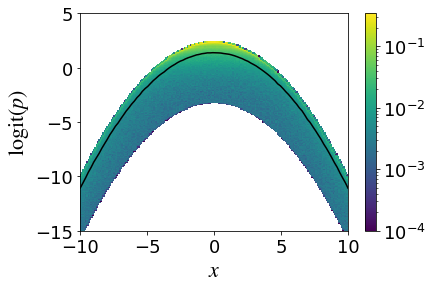

In [26]:
plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
bins=200
plt.hist2d(training_x[:N], training_logit_p[:N], bins=bins, range=((-10, 10),(-15,5)), \
                                       weights=np.full(N, bins**2./(N*20.*20.)), norm=LogNorm())
x = np.linspace(-10, 10, 100)
plt.plot(x, logit(cat.boundaries(x)[0]), color='black')
plt.colorbar()
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$\mathrm{logit}(p)$', fontsize=22)
ax.set_rasterized(True)
plt.savefig('x_logit_depcut.pdf', bbox_inches='tight')

In [27]:
testing_categories = cat.categorize(testing_x, testing_p)
selected_x = testing_x[testing_categories==0]
selected_p = testing_p[testing_categories==0]
selected_y = testing_y[testing_categories==0]

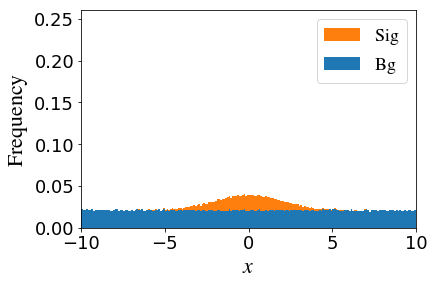

In [28]:
Nb_ = testing_x[testing_y==0].size
Ns_ = testing_x[testing_y==1].size

Nb = selected_x[selected_y==0].size
Ns = selected_x[selected_y==1].size
bins = 200

plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
ax.hist([selected_x[selected_y==0], selected_x[selected_y==1]], stacked=True, bins=bins, \
                                    range=(-10, 10), weights=[np.full(Nb, bins/(20.*Nb_)), np.full(Ns, bins/(20.*Ns_))], \
                                    label=[r"$\mathrm{Bg}$", r"$\mathrm{Sig}$"], histtype='stepfilled')
ax.set_xlim(-10, 10)
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$\mathrm{Frequency}$', fontsize=22)
ax.legend()
ax.set_ylim(0, 0.260)
plt.savefig('dep_selection.pdf', bbox_inches='tight')

plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
ax.hist([selected_x[selected_y==0], selected_x[selected_y==1]], stacked=True, bins=200, \
                                    range=(-10, 10), weights=[np.full(Nb, bins/(20.*Nb_)), np.full(Ns, (1/9.)*bins/(20.*Ns_))], \
                                    label=[r"$\mathrm{Bg}$", r"$\mathrm{Sig}$"], histtype='stepfilled')
ax.set_xlim(-10, 10)
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$\mathrm{Frequency}$', fontsize=22)
ax.set_ylim(0, 0.260)
ax.legend()
plt.savefig('dep_selection_10percent.pdf', bbox_inches='tight')

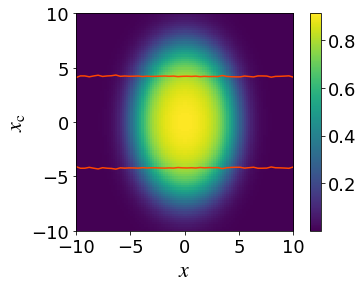

In [29]:
x1 = np.linspace(-10, 10, 100)
x2 = np.linspace(-10, 10, 100)
x1, x2 = np.meshgrid(x1, x2)
sig_pdf_val = sig_pdf(np.array([x1.T,x2.T]).T)
prob_val = prob_function(np.array([x1.T,x2.T]).T)

plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
plt.imshow(prob_val, extent=[-10, 10, -10, 10])
plt.colorbar()
x = np.linspace(-10, 10, 50)
plt.plot(x, reverse_prob_e_1(cat.boundaries(x)[0], x), color='orangered')
plt.plot(x, -reverse_prob_e_1(cat.boundaries(x)[0], x), color='orangered')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$x_\mathrm{c}$', fontsize=22)
plt.savefig('depcut_p_plot.pdf', bbox_inches='tight')

In [30]:
reverse_prob_e_1(cat.boundaries(x)[0], x)

array([4.09158915, 4.2478006 , 4.24479988, 4.16326864, 4.24278359,
       4.30991079, 4.19756276, 4.24253388, 4.26265124, 4.32562688,
       4.20891619, 4.23835743, 4.21505189, 4.21946196, 4.2362873 ,
       4.19287768, 4.22201935, 4.20219193, 4.20657511, 4.2215414 ,
       4.23343248, 4.21015473, 4.23149757, 4.17977686, 4.21005098,
       4.21986559, 4.20017072, 4.2241066 , 4.1780475 , 4.21048445,
       4.18469464, 4.19750914, 4.18522282, 4.28123214, 4.19867824,
       4.17026913, 4.15996809, 4.15868465, 4.2349306 , 4.19252434,
       4.15360118, 4.24586282, 4.24307627, 4.23278905, 4.12867734,
       4.20322466, 4.21020479, 4.22922146, 4.25204379, 4.12941403])

In [31]:
import thickbrick._statisticaldistances as statdist
statdist.Pearson_chisq.eventwise_contrib_func(np.array([1e-6, .25, .5]), np.array([1e-6, .25, .5]))

array([1.00000100e-12, 8.33333333e-02, 5.00000000e-01])

In [32]:
autocategorizer = taab.Autocategorizer(category_count=1, allow_rejection=True, statistical_distance="Neyman_chisq", \
                                       regression_method=kerreg.NW_kerreg_1d, default_regression_options={'bandwidth': .01})
autocategorizer.set_data(x = training_x, p = training_p)
autocategorizer.initialize_categorizer(mode='random_assignment')
for i in range(20):
    print(f"Training step {i+1:2}: ", end='')
    print(autocategorizer.training_step())

Training step  1: {'category_reassignment_count': 499976}
Training step  2: {'category_reassignment_count': 35378}
Training step  3: {'category_reassignment_count': 7279}
Training step  4: {'category_reassignment_count': 1630}
Training step  5: {'category_reassignment_count': 353}
Training step  6: {'category_reassignment_count': 85}
Training step  7: {'category_reassignment_count': 19}
Training step  8: {'category_reassignment_count': 3}
Training step  9: {'category_reassignment_count': 0}
Training step 10: {'category_reassignment_count': 0}
Training step 11: {'category_reassignment_count': 0}
Training step 12: {'category_reassignment_count': 0}
Training step 13: {'category_reassignment_count': 0}
Training step 14: {'category_reassignment_count': 0}
Training step 15: {'category_reassignment_count': 0}
Training step 16: {'category_reassignment_count': 0}
Training step 17: {'category_reassignment_count': 0}
Training step 18: {'category_reassignment_count': 0}
Training step 19: {'categor

In [33]:
cat = autocategorizer.get_current_categorizer()
print(evaluator.evaluate(cat, 1))
print(evaluator.evaluate(cat, 1, signal_scale=1./9))

2.0039933985300107
0.044520834789720715


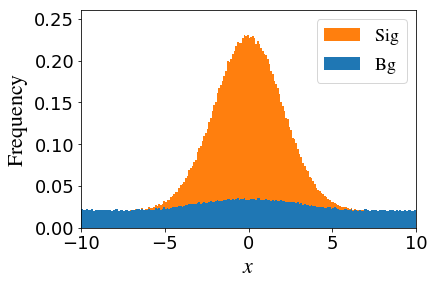

In [34]:
testing_categories = cat.categorize(testing_x, testing_p)
selected_x = testing_x[testing_categories==0]
selected_p = testing_p[testing_categories==0]
selected_y = testing_y[testing_categories==0]

Nb_ = testing_x[testing_y==0].size
Ns_ = testing_x[testing_y==1].size

Nb = selected_x[selected_y==0].size
Ns = selected_x[selected_y==1].size
bins = 200

plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
ax.hist([selected_x[selected_y==0], selected_x[selected_y==1]], stacked=True, bins=bins, \
                                    range=(-10, 10), weights=[np.full(Nb, bins/(20.*Nb_)), np.full(Ns, bins/(20.*Ns_))], \
                                    label=[r"$\mathrm{Bg}$", r"$\mathrm{Sig}$"], histtype='stepfilled')
ax.set_xlim(-10, 10)
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$\mathrm{Frequency}$', fontsize=22)
ax.legend()
ax.set_ylim(0, 0.260)
plt.savefig('dep_selection_neym.pdf', bbox_inches='tight')

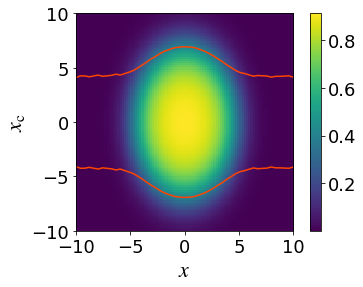

In [35]:
x1 = np.linspace(-10, 10, 100)
x2 = np.linspace(-10, 10, 100)
x1, x2 = np.meshgrid(x1, x2)
sig_pdf_val = sig_pdf(np.array([x1.T,x2.T]).T)
prob_val = prob_function(np.array([x1.T,x2.T]).T)

plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
plt.imshow(prob_val, extent=[-10, 10, -10, 10])
plt.colorbar()
x = np.linspace(-10, 10, 50)
plt.plot(x, reverse_prob_e_1(cat.boundaries(x)[0], x), color='orangered')
plt.plot(x, -reverse_prob_e_1(cat.boundaries(x)[0], x), color='orangered')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$x_\mathrm{c}$', fontsize=22)
plt.savefig('depcut_p_plot_neym.pdf', bbox_inches='tight')

In [36]:
autocategorizer = taab.Autocategorizer(category_count=2, allow_rejection=False, statistical_distance="Pearson_chisq", \
                                       regression_method=kerreg.NW_kerreg_1d, default_regression_options={'bandwidth': .01})
autocategorizer.set_data(x = training_x, p = training_p)
autocategorizer.initialize_categorizer(mode='random_assignment')
for i in range(20):
    print(f"Training step {i+1:2}: ", end='')
    print(autocategorizer.training_step())

Training step  1: {'category_reassignment_count': 499504}
Training step  2: {'category_reassignment_count': 29451}
Training step  3: {'category_reassignment_count': 11245}
Training step  4: {'category_reassignment_count': 4262}
Training step  5: {'category_reassignment_count': 1565}
Training step  6: {'category_reassignment_count': 560}
Training step  7: {'category_reassignment_count': 222}
Training step  8: {'category_reassignment_count': 68}
Training step  9: {'category_reassignment_count': 26}
Training step 10: {'category_reassignment_count': 6}
Training step 11: {'category_reassignment_count': 2}
Training step 12: {'category_reassignment_count': 0}
Training step 13: {'category_reassignment_count': 0}
Training step 14: {'category_reassignment_count': 0}
Training step 15: {'category_reassignment_count': 0}
Training step 16: {'category_reassignment_count': 0}
Training step 17: {'category_reassignment_count': 0}
Training step 18: {'category_reassignment_count': 0}
Training step 19: {'c

In [37]:
cat = autocategorizer.get_current_categorizer()
print(evaluator.evaluate(cat, 2))
print(evaluator.evaluate(cat, 2, signal_scale=1./9))

2.4433786358137533
0.05428272441094917


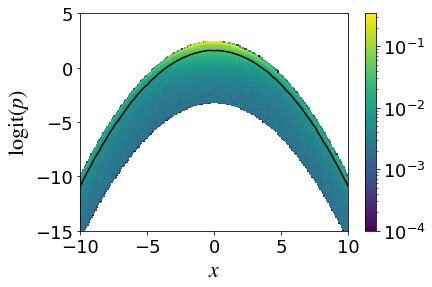

In [38]:
plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
bins=200
plt.hist2d(training_x[:N], training_logit_p[:N], bins=bins, range=((-10, 10),(-15,5)), \
                                       weights=np.full(N, bins**2./(N*20.*20.)), norm=LogNorm())
x = np.linspace(-10, 10, 100)
plt.plot(x, logit(cat.boundaries(x)[0]), color='black')
plt.colorbar()
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$\mathrm{logit}(p)$', fontsize=22)
ax.set_rasterized(True)
plt.savefig('x_logit_depcut2.pdf', bbox_inches='tight')

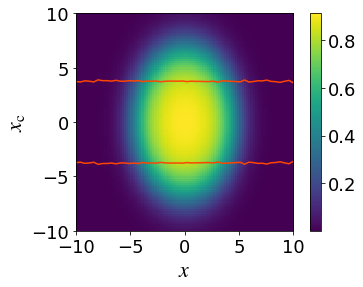

In [39]:
x1 = np.linspace(-10, 10, 100)
x2 = np.linspace(-10, 10, 100)
x1, x2 = np.meshgrid(x1, x2)
sig_pdf_val = sig_pdf(np.array([x1.T,x2.T]).T)
prob_val = prob_function(np.array([x1.T,x2.T]).T)

plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
plt.imshow(prob_val, extent=[-10, 10, -10, 10])
plt.colorbar()
x = np.linspace(-10, 10, 50)
plt.plot(x, reverse_prob_e_1(cat.boundaries(x)[0], x), color='orangered')
plt.plot(x, -reverse_prob_e_1(cat.boundaries(x)[0], x), color='orangered')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$x_\mathrm{c}$', fontsize=22)
plt.savefig('depcut_p_plot2.pdf', bbox_inches='tight')

In [40]:
autocategorizer = taab.Autocategorizer(category_count=3, allow_rejection=False, statistical_distance="Pearson_chisq", \
                                       regression_method=kerreg.NW_kerreg_1d, default_regression_options={'bandwidth': .05})
autocategorizer.set_data(x = training_x, p = training_p)
autocategorizer.initialize_categorizer(mode='random_assignment')
for i in range(30):
    print(f"Training step {i+1:2}: ", end='')
    print(autocategorizer.training_step())

Training step  1: {'category_reassignment_count': 667488}
Training step  2: {'category_reassignment_count': 185362}
Training step  3: {'category_reassignment_count': 37705}
Training step  4: {'category_reassignment_count': 17241}
Training step  5: {'category_reassignment_count': 11807}
Training step  6: {'category_reassignment_count': 8232}
Training step  7: {'category_reassignment_count': 5877}
Training step  8: {'category_reassignment_count': 4199}
Training step  9: {'category_reassignment_count': 3007}
Training step 10: {'category_reassignment_count': 2192}
Training step 11: {'category_reassignment_count': 1548}
Training step 12: {'category_reassignment_count': 1119}
Training step 13: {'category_reassignment_count': 797}
Training step 14: {'category_reassignment_count': 543}
Training step 15: {'category_reassignment_count': 391}
Training step 16: {'category_reassignment_count': 304}
Training step 17: {'category_reassignment_count': 204}
Training step 18: {'category_reassignment_coun

In [41]:
cat = autocategorizer.get_current_categorizer()
print(evaluator.evaluate(cat, 3))
print(evaluator.evaluate(cat, 3, signal_scale=1./9))

2.570254252449096
0.057101402731043804


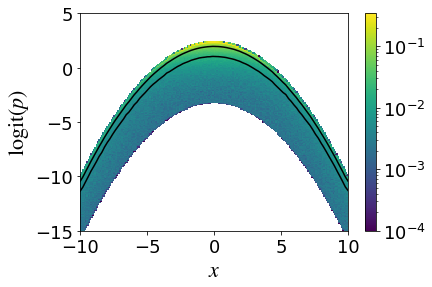

In [42]:
plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
bins=200
plt.hist2d(training_x[:N], training_logit_p[:N], bins=bins, range=((-10, 10),(-15,5)), \
                                       weights=np.full(N, bins**2./(N*20.*20.)), norm=LogNorm())
x = np.linspace(-10, 10, 100)
plt.plot(x, logit(cat.boundaries(x)[0]), color='black')
plt.plot(x, logit(cat.boundaries(x)[1]), color='black')
plt.colorbar()
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$\mathrm{logit}(p)$', fontsize=22)
ax.set_rasterized(True)
plt.savefig('x_logit_depcut3.pdf', bbox_inches='tight')

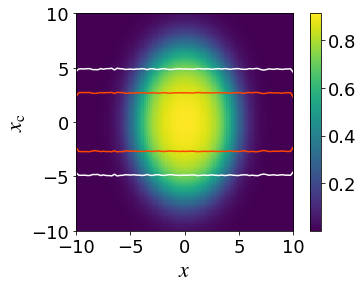

In [43]:
x1 = np.linspace(-10, 10, 100)
x2 = np.linspace(-10, 10, 100)
x1, x2 = np.meshgrid(x1, x2)
sig_pdf_val = sig_pdf(np.array([x1.T,x2.T]).T)
prob_val = prob_function(np.array([x1.T,x2.T]).T)

plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
plt.imshow(prob_val, extent=[-10, 10, -10, 10])
plt.colorbar()
x = np.linspace(-10, 10, 80)
plt.plot(x, reverse_prob_e_1(cat.boundaries(x)[1], x), color='orangered')
plt.plot(x, -reverse_prob_e_1(cat.boundaries(x)[1], x), color='orangered')
plt.plot(x, reverse_prob_e_1(cat.boundaries(x)[0], x), color='white')
plt.plot(x, -reverse_prob_e_1(cat.boundaries(x)[0], x), color='white')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$x_\mathrm{c}$', fontsize=22)
plt.savefig('depcut_p_plot3.pdf', bbox_inches='tight')

In [44]:
autocategorizer = taab.Autocategorizer(category_count=4, allow_rejection=False, statistical_distance="Pearson_chisq", \
                                       regression_method=kerreg.NW_kerreg_1d, default_regression_options={'bandwidth': .05})
autocategorizer.set_data(x = training_x, p = training_p)
autocategorizer.initialize_categorizer(mode='random_assignment')
for i in range(40):
    print(f"Training step {i+1:2}: ", end='')
    print(autocategorizer.training_step())

Training step  1: {'category_reassignment_count': 750633}
Training step  2: 

/home/prasanth/.local/lib/python3.7/site-packages/thickbrick/KernelRegression/_NW_kerreg_1d.py:55: RuntimeWarning: divide by zero encountered in true_divide
  return Nr/Dr


{'category_reassignment_count': 187035}
Training step  3: {'category_reassignment_count': 95187}
Training step  4: {'category_reassignment_count': 48787}
Training step  5: {'category_reassignment_count': 25897}
Training step  6: {'category_reassignment_count': 14984}
Training step  7: {'category_reassignment_count': 11393}
Training step  8: {'category_reassignment_count': 9278}
Training step  9: {'category_reassignment_count': 7586}
Training step 10: {'category_reassignment_count': 6406}
Training step 11: {'category_reassignment_count': 5377}
Training step 12: {'category_reassignment_count': 4469}
Training step 13: {'category_reassignment_count': 3863}
Training step 14: {'category_reassignment_count': 3273}
Training step 15: {'category_reassignment_count': 2753}
Training step 16: {'category_reassignment_count': 2258}
Training step 17: {'category_reassignment_count': 1835}
Training step 18: {'category_reassignment_count': 1498}
Training step 19: {'category_reassignment_count': 1273}
Tra

In [45]:
cat = autocategorizer.get_current_categorizer()
print(evaluator.evaluate(cat, 4))
print(evaluator.evaluate(cat, 4, signal_scale=1./9))

2.609865658293844
0.0579814679238619


In [46]:
autocategorizer = taab.Autocategorizer(category_count=5, allow_rejection=False, statistical_distance="Pearson_chisq", \
                                       regression_method=kerreg.NW_kerreg_1d, default_regression_options={'bandwidth': .05})
autocategorizer.set_data(x = training_x, p = training_p)
autocategorizer.initialize_categorizer(mode='random_assignment')
for i in range(50):
    print(f"Training step {i+1:2}: ", end='')
    print(autocategorizer.training_step())

Training step  1: {'category_reassignment_count': 799220}
Training step  2: {'category_reassignment_count': 187796}
Training step  3: {'category_reassignment_count': 133662}
Training step  4: {'category_reassignment_count': 87395}
Training step  5: {'category_reassignment_count': 56410}
Training step  6: {'category_reassignment_count': 36064}
Training step  7: {'category_reassignment_count': 23348}
Training step  8: {'category_reassignment_count': 16622}
Training step  9: {'category_reassignment_count': 12653}
Training step 10: {'category_reassignment_count': 10091}
Training step 11: {'category_reassignment_count': 8700}
Training step 12: {'category_reassignment_count': 7516}
Training step 13: {'category_reassignment_count': 6548}
Training step 14: {'category_reassignment_count': 5832}
Training step 15: {'category_reassignment_count': 5282}
Training step 16: {'category_reassignment_count': 4829}
Training step 17: {'category_reassignment_count': 4247}
Training step 18: {'category_reassi

In [47]:
for i in range(10):
    print(f"Training step {i+1:2}: ", end='')
    print(autocategorizer.training_step())

Training step  1: {'category_reassignment_count': 102}
Training step  2: {'category_reassignment_count': 86}
Training step  3: {'category_reassignment_count': 76}
Training step  4: {'category_reassignment_count': 78}
Training step  5: {'category_reassignment_count': 75}
Training step  6: {'category_reassignment_count': 56}
Training step  7: {'category_reassignment_count': 42}
Training step  8: {'category_reassignment_count': 24}
Training step  9: {'category_reassignment_count': 22}
Training step 10: {'category_reassignment_count': 19}


In [48]:
cat = autocategorizer.get_current_categorizer()
print(evaluator.evaluate(cat, 5))
print(evaluator.evaluate(cat, 5, signal_scale=1./9))

2.627207087190996
0.05836677147444779


In [49]:
#flat_dpear = (2.2541467360632974, 0.12063895415847345)
flat_dpear = (2.221429528761556, 0.1214151763430718)
depcut_dpear = (2.363982838707199, 0.12547061379027466)
dep_2cat_dpear = (2.4433786358137533, 0.12954005614060393)
dep_3cat_dpear = (2.570254252449096, 0.1382612730979736)
dep_4cat_dpear = (2.609865658293844, 0.14097547858171805)
dep_5cat_dpear = (2.627207958510764, 0.14216789806430505)
u_lim = (2.655816536749596, 0.14413832109553512)

print(depcut_dpear[0]/flat_dpear[0], depcut_dpear[1]/flat_dpear[1])
print(dep_2cat_dpear[0]/flat_dpear[0], dep_2cat_dpear[1]/flat_dpear[1])
print(dep_3cat_dpear[0]/flat_dpear[0], dep_3cat_dpear[1]/flat_dpear[1])

1.064171880359003 1.0334014047448548
1.0999127382519012 1.0669181567102815
1.1570271391332452 1.1387478671307227


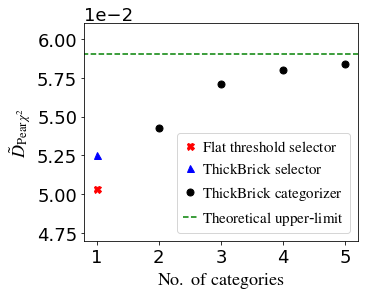

In [50]:
plt.close()
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
ax.set_aspect(250)
plt.plot([1], [0.05032774574910479], 'rX', markersize=7, label=r"$\mathrm{Flat\ threshold\ selector}$")
plt.plot([1], [0.052518579680015186], 'b^', markersize=7, label=r"$\mathrm{ThickBrick\ selector}$")
plt.plot([2, 3, 4, 5], [0.05428272441094917, 0.057101402731043804, 0.0579814679238619, 0.05836677147444779], 'ko', markersize=7, label=r"$\mathrm{ThickBrick\ categorizer}$")
plt.plot(np.linspace(0, 6, 10), np.full(10, 0.05900236369510426), 'g--', label=r"$\mathrm{Theoretical\ upper}$-$\mathrm{limit}$")
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlim(.8, 5.2)
ax.set_ylim(.047, .061)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel(r"$\mathrm{No.\ of\ categories}$")
plt.ylabel(r"$\tilde{D}_{\mathrm{Pear}\,\chi^2}$")
plt.legend(fontsize=15, handlelength=1, handletextpad=.3)
plt.savefig('moneyplot.pdf', bbox_inches='tight')

In [51]:
evaluator2 = taab.Evaluator(statistical_distance="Pearson_chisq", \
                                       regression_method=kerreg.NW_kerreg_1d, default_regression_options={'bandwidth': .01})
evaluator2.set_data(x = training_x, p = training_p)

In [52]:
print(evaluator2.evaluate(const_cat(.777), 1, 1./9))
print(evaluator2.evaluate(const_cat(.778), 1, 1./9))
print(evaluator2.evaluate(const_cat(.779), 1, 1./9))

print(evaluator2.evaluate(const_cat(.714), 1, 1./9))
print(evaluator2.evaluate(const_cat(.715), 1, 1./9))
print(evaluator2.evaluate(const_cat(.716), 1, 1./9))

0.049382915719796534
0.04934185249100341
0.04929928666433187
0.05032669217461904
0.05032774574910479
0.05032598187465535


In [53]:
print(evaluator2.evaluate(const_cat(.714), 1))
print(evaluator2.evaluate(const_cat(.715), 1))
print(evaluator2.evaluate(const_cat(.716), 1))

2.2653921201144116
2.265438893472276
2.265361257843895


In [54]:
(logit(.778), logit(.715))

(1.2540491423061124, 0.919793362425357)

In [55]:
evaluator.evaluate(const_cat(.715), 1, 1./9)

0.050326381636570904

In [56]:
evaluator.upper_limit(signal_scale=1/9)

0.05900236369510426